In [1]:
import numpy as np
pi = np.pi

from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *

from qutip.qip.device import *
from qutip.qip import pulse

#print(qutip.qip.device.__file__)
import qip.ethprocessor as qip
from qip.ethprocessor import ETHProcessor

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# One qubit test

## Create a Quantum Circuit

In [2]:
# Number of qubits in the system
N = 1

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N)

# Hadamard Gate
qc.add_gate("RZ", 0, None, np.pi/2, r"\pi/2")
qc.add_gate("RX", 0, None, np.pi/2, r"\pi/2")
qc.add_gate("RZ", 0, None, np.pi/2, r"\pi/2")

qc.png

### Resulting unitary

In [3]:
U_list = qc.propagators()
U = gate_sequence_product(U_list)
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.-0.70710678j 0.-0.70710678j]
 [0.-0.70710678j 0.+0.70710678j]]

### ETH Processor

In [4]:
eth = ETHProcessor()  
tlist, coeffs = eth.load_circuit(qc)

### Plot pulses

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9aa19df100>)

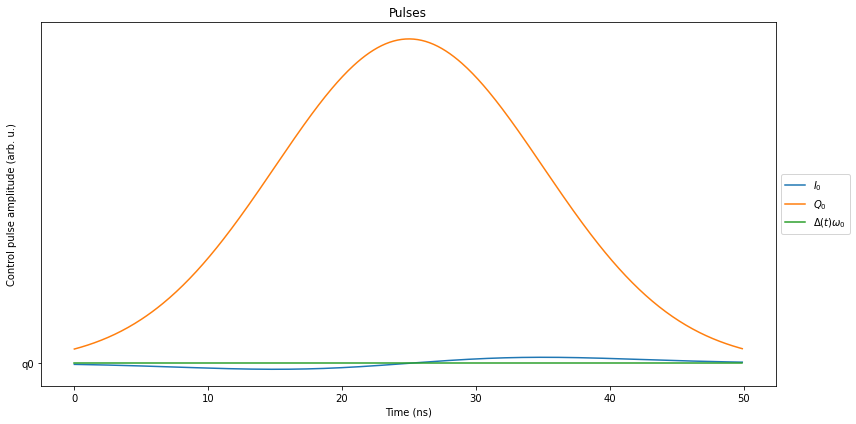

In [5]:
eth.plot_pulses(title='Pulses')

## Execute quantum circuit

In [6]:
vac = basis(3,0)
noisy = False
result = eth.run_state(init_state = vac, noisy = noisy)
final_state = result.states[-1]

### Transform to the transmon frame and project onto qubit subspace

In [7]:
H_drift = eth.drift.drift_hamiltonians[0].qobj # Qubit Hamiltonian
t_total = tlist[-1]
U_rot = (1j*H_drift*t_total).expm()

# target state
U_list = qc.propagators()
U = gate_sequence_product(U_list)

target_state = U*basis(2,0)
if noisy is True:
    transmon_state = U_rot * final_state * U_rot.dag()
    target_state = target_state * target_state.dag()
    # project onto qubit subspace
    qubit_state = Qobj(transmon_state.data[0:2,0:2], dims = [[2],[2]])
else:
    transmon_state = U_rot * final_state
    # project onto qubit subspace
    qubit_state = Qobj(transmon_state.data[0:2], dims = [[2],[1]])

### Fidelity

In [8]:
# fidelity
fid = fidelity(target_state, qubit_state)
print('Fidelity = %s %%' % round(fid*100,4)) # Should be close to 100 %

Fidelity = 100.0 %


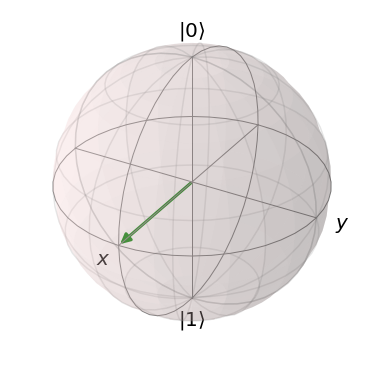

In [9]:
qubit_state
b = Bloch()
b.add_states(qubit_state)
b.show()

# Two qubit test
## Quantum Circuit

In [10]:
# Number of qubits in the system
N = 2

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)

qc.add_gate("RZ", 0, None, np.pi/2, r"\pi")
qc.add_gate("RX", 0, None, np.pi, r"\pi")
qc.add_gate("RX", 1, None, np.pi, r"\pi")
#qc.add_gate("RX", 0, None, np.pi/2, r"\pi/2")
#qc.png

### ETH Processor

In [11]:
from qip.ethprocessor import ETHProcessor
eth = ETHProcessor()
tlist, coeffs = eth.load_circuit(qc)

### Plot pulses

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9a40015b20>)

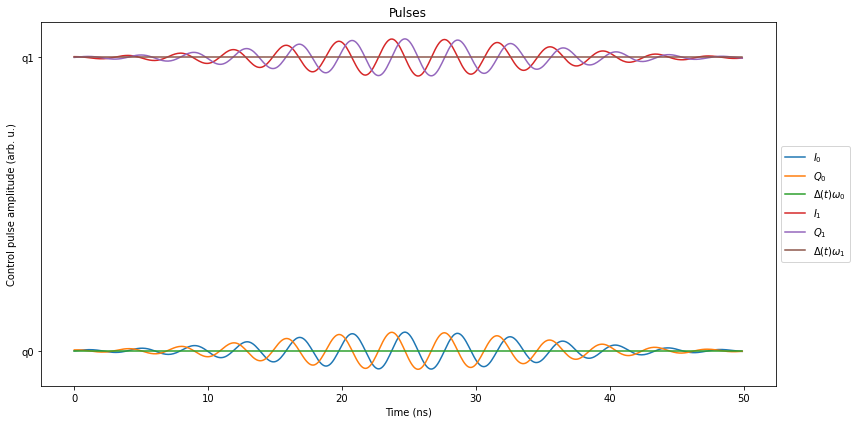

In [12]:
eth.plot_pulses(title='Pulses')

## Run state

In [13]:
final_state

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 7.07231886e-01-0.00708147j]
 [ 7.06904002e-01-0.00767299j]
 [-5.64023978e-05+0.00087533j]]

In [14]:
psi = tensor(basis(3,0),basis(3,0)) # vacuum
result = eth.run_state(init_state = psi, analytical = False, noisy=True)
final_state = result.states[-1]

### Transform to the transmon frame

In [15]:
H_drift = eth.drift.drift_hamiltonians[0].qobj # Qubit Hamiltonian
t_total = tlist[-1]
U_rot = (1j*H_drift*t_total).expm()
transmon_state = U_rot * final_state

In [16]:
# project onto qubit subspace
qubit_state = (tensor(basis(2,0),basis(2,0))*tensor(basis(3,0),basis(3,0)).dag() \
               + tensor(basis(2,1),basis(2,1))*tensor(basis(3,1),basis(3,1)).dag() \
               + tensor(basis(2,0),basis(2,1))*tensor(basis(3,0),basis(3,1)).dag() \
               + tensor(basis(2,1),basis(2,0))*tensor(basis(3,1),basis(3,0)).dag()) * transmon_state

# target state
U_list = qc.propagators()
target_state = gate_sequence_product(U_list) * tensor(basis(2,0),basis(2,0))

print(target_state)

# fidelity
fid = fidelity(qubit_state,target_state)
print('Fidelity = %s %%' % round(fid*100,4)) # Should be close to 100 %

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.70710678+0.70710678j]]


TypeError: Density matrices do not have same dimensions.

## CZ gate

In [59]:
# Number of qubits in the system
N = 2

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False, input_states = [0] * N)
qc.add_gate("RX", 0, None, np.pi, r"\pi")
qc.add_gate("RX", 1, None, np.pi/2, r"\pi")
qc.add_gate("CSIGN", controls=0, targets=1)
#qc.png

In [60]:
from qip.ethprocessor import ETHProcessor
eth = ETHProcessor()
tlist, coeffs = eth.load_circuit(qc)

0
0
0
1
1
1


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ad088d9d0>)

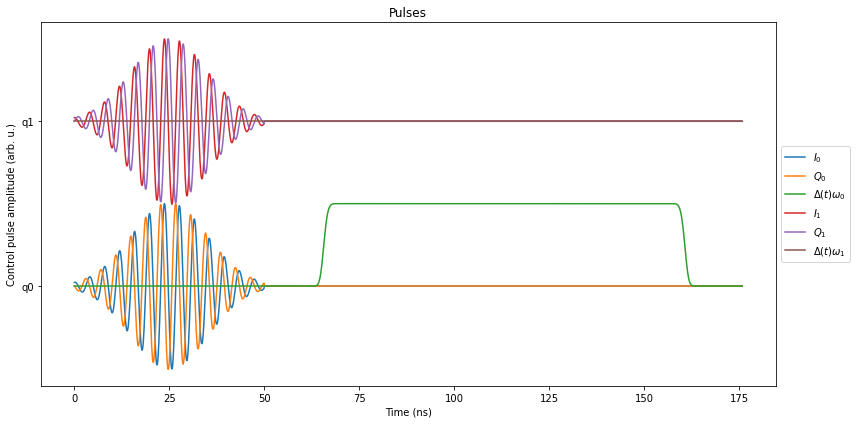

In [61]:
eth.plot_pulses(title='Pulses')

In [20]:
psi = tensor(basis(3,1),basis(3,1)) # vacuum
result = eth.run_state(init_state = psi, noisy=False)
final_state = result.states[-1]

In [21]:
H_drift = eth.drift.drift_hamiltonians[0].qobj # Qubit Hamiltonian
t_total = tlist[-1]
U_rot = (1j*H_drift*t_total).expm()
transmon_state = U_rot * final_state

In [22]:
# project onto qubit subspace
qubit_state = (tensor(basis(2,0),basis(2,0))*tensor(basis(3,0),basis(3,0)).dag() \
               + tensor(basis(2,1),basis(2,1))*tensor(basis(3,1),basis(3,1)).dag() \
               + tensor(basis(2,0),basis(2,1))*tensor(basis(3,0),basis(3,1)).dag() \
               + tensor(basis(2,1),basis(2,0))*tensor(basis(3,1),basis(3,0)).dag()) * transmon_state

# target state
U_list = qc.propagators()
target_state = gate_sequence_product(U_list) * tensor(basis(2,1),basis(2,1))

# fidelity
fid = fidelity(qubit_state,target_state)
print('Fidelity = %s %%' % round(fid*100,4)) # Should be close to 100 %

Fidelity = 99.9639 %
